# 1D GAN

## Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.functional as F
from torch import nn
import math
import matplotlib.pyplot as plt

In [2]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
    torch.cuda.empty_cache()

print(device)

cuda


## Generator

In [3]:
class Generator(nn.Module):
    def __init__(self, nz, ngf):
        super(Generator, self).__init__()

        assert(ngf % 32 == 0 and ngf >= 32)

        self.main = nn.Sequential(
            nn.ConvTranspose1d(
                in_channels=nz,
                out_channels=ngf,
                kernel_size=4,
                stride=1,
                padding=0,
                dilation=1,
                bias=False,
            ),
            nn.BatchNorm1d(ngf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.2),

            nn.ConvTranspose1d(
                in_channels=ngf,
                out_channels=ngf // 2,
                kernel_size=4,
                stride=2,
                padding=0,
                dilation=1,
                bias=False,
            ),
            nn.BatchNorm1d(ngf // 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.2),

            nn.ConvTranspose1d(
                in_channels=ngf // 2,
                out_channels=ngf // 4,
                kernel_size=4,
                stride=2,
                padding=0,
                dilation=1,
                bias=False,
            ),
            nn.BatchNorm1d(ngf // 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.2),

            nn.ConvTranspose1d(
                in_channels=ngf // 4,
                out_channels=ngf // 8,
                kernel_size=4,
                stride=2,
                padding=0,
                dilation=1,
                bias=False,
            ),
            nn.BatchNorm1d(ngf // 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.2),

            nn.ConvTranspose1d(
                in_channels=ngf // 8,
                out_channels=1,
                kernel_size=10,
                stride=2,
                padding=0,
                dilation=1,
                bias=False,
            ),
            nn.Tanh(),
        )

    def forward(self, input):
        return self.main(input)

## Discriminator

In [4]:
class Discriminator(nn.Module):
    def __init__(self, ndf):
        super(Discriminator, self).__init__()

        assert(ndf % 16 == 0 and ndf >= 16)

        self.main = nn.Sequential(
            nn.Conv1d(
                in_channels=1,
                out_channels=(ndf // 16),
                kernel_size=4,
                stride=1,
                padding=0,
                dilation=1,
                bias=False
            ),
            nn.BatchNorm1d(ndf // 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.2),

            nn.Conv1d(
                in_channels=(ndf // 16),
                out_channels=(ndf // 8),
                kernel_size=4,
                stride=2,
                padding=0,
                dilation=1,
                bias=False
            ),
            nn.BatchNorm1d(ndf // 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.2),

            nn.Conv1d(
                in_channels=(ndf // 8),
                out_channels=(ndf // 4),
                kernel_size=4,
                stride=2,
                padding=0,
                dilation=1,
                bias=False,
            ),
            nn.BatchNorm1d(ndf // 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.2),

            nn.Conv1d(
                in_channels=(ndf // 4),
                out_channels=(ndf // 2),
                kernel_size=4,
                stride=2,
                padding=0,
                dilation=1,
                bias=False
            ),
            nn.BatchNorm1d(ndf // 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.2),

            nn.Conv1d(
                in_channels=(ndf // 2),
                out_channels=ndf,
                kernel_size=4,
                stride=2,
                padding=0,
                dilation=1,
                bias=False
            ),
            nn.BatchNorm1d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.2),

            nn.Conv1d(
                in_channels=ndf,
                out_channels=1,
                kernel_size=4,
                stride=2,
                padding=0,
                dilation=1,
                bias=False
            ),
        )

    def forward(self, input):
        return self.main(input)

## Training

In [5]:


# Hyperparameters
instance_to_resume = 13
num_epochs = 5000
batch_size = 100
learning_rate = 5e-5
beta1 = 0.9
nz = 100  # Number of values ("features") in the noise supplised to generator
ngf = 512  # Number of generator feature maps (how many channels it will generate for each noise feature)
ndf = 512  # Number of discriminator feature maps


In [6]:
# Load all of our songs
N = 40
C_in = 1 # Number of channels in the input data
train_data_length = 100

train_data = torch.zeros((batch_size,C_in,train_data_length))

In [7]:
train_data[:,0,:]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [8]:
train_data[:, 0] 

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

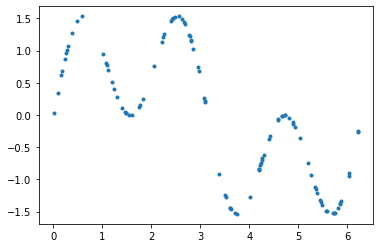

In [9]:

timebase= 2*math.pi*torch.rand(train_data_length)
train_data[:, 0] = torch.sin(timebase)+torch.sin(3*timebase)+0.001*torch.randn(train_data_length)
dataset = torch.rand([batch_size, C_in, train_data_length])
plt.plot(timebase, train_data[0, 0,:], ".")

In [10]:

train_data.size()

torch.Size([100, 1, 100])

In [11]:

real_label = 1
fake_label = 0
hard_real_labels = torch.full((batch_size,), real_label, dtype=torch.float32, device=device, requires_grad=False)
hard_fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float32, device=device, requires_grad=False)



# Create loader
data_loader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True
)

# Create models
generator = Generator(nz, ngf).to(device)
discriminator = Discriminator(ndf).to(device)

# Create optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))

# Create loss function
loss_func = nn.BCEWithLogitsLoss()

# Train
for epoch in range(num_epochs):
    for i, data in enumerate(data_loader):
        actual_batch_size = data.size()[0]
        #sample_length = data.size()[2]
        real_batch = data.to(device)

        # Soften labels (probably don't need to do this every batch as the loader shuffles anyway)
        real_labels = torch.randn_like(hard_real_labels) * 0.10 + hard_real_labels
        fake_labels = torch.randn_like(hard_fake_labels) * 0.10 + hard_fake_labels

        # Train generator
        generator_optimizer.zero_grad()
        noise = torch.randn(actual_batch_size, nz, 1, device=device)
        fake_batch = generator(noise)
        fake_output = discriminator(fake_batch).view(-1)
        generator_loss = loss_func(fake_output, real_labels[:actual_batch_size])
        generator_loss.backward()
        generator_optimizer.step()

        # Train discriminator
        discriminator_optimizer.zero_grad()
        real_output = discriminator(real_batch).view(-1)
        fake_output = discriminator(fake_batch.detach()).view(-1)
        real_loss = loss_func(real_output, real_labels[:actual_batch_size])
        fake_loss = loss_func(fake_output, fake_labels[:actual_batch_size])
        discriminator_loss = fake_loss + real_loss
        discriminator_loss.backward()
        discriminator_optimizer.step()

        # Keep statistics
        gen_grad_param_norms = []
        for param in generator.parameters():
            gen_grad_param_norms.append(param.grad.norm())
        mean_gen_grad_norm = torch.tensor(gen_grad_param_norms).mean().item()
        disc_grad_param_norms = []
        for param in discriminator.parameters():
            disc_grad_param_norms.append(param.grad.norm())
        mean_disc_grad_norm = torch.tensor(disc_grad_param_norms).mean().item()
        mean_real_output = real_output.mean().item()
        mean_fake_output = fake_output.mean().item()
        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], loss_g: {generator_loss:.4f}, loss_d: {discriminator_loss:.4f}, mean_real_output: {mean_real_output:.4f}, mean_fake_output: {mean_fake_output:.4f}, mean_gen_grad_norm: {mean_gen_grad_norm:.4f}, mean_disc_grad_norm: {mean_disc_grad_norm:.4f}")

Epoch [1/5000], loss_g: 0.6405, loss_d: 1.3590, mean_real_output: 0.2982, mean_fake_output: 0.1034, mean_gen_grad_norm: 0.8090, mean_disc_grad_norm: 1.0827
Epoch [2/5000], loss_g: 0.6364, loss_d: 1.2618, mean_real_output: 0.6151, mean_fake_output: 0.1736, mean_gen_grad_norm: 0.8334, mean_disc_grad_norm: 0.9565
Epoch [3/5000], loss_g: 0.6179, loss_d: 1.1284, mean_real_output: 0.9502, mean_fake_output: 0.1459, mean_gen_grad_norm: 0.7882, mean_disc_grad_norm: 0.8723
Epoch [4/5000], loss_g: 0.6347, loss_d: 1.0941, mean_real_output: 1.2452, mean_fake_output: 0.1747, mean_gen_grad_norm: 0.7928, mean_disc_grad_norm: 0.7657
Epoch [5/5000], loss_g: 0.6558, loss_d: 1.0037, mean_real_output: 1.4397, mean_fake_output: 0.1325, mean_gen_grad_norm: 0.7968, mean_disc_grad_norm: 0.7697
Epoch [6/5000], loss_g: 0.6685, loss_d: 0.9574, mean_real_output: 1.7062, mean_fake_output: 0.0451, mean_gen_grad_norm: 0.8081, mean_disc_grad_norm: 0.7164
Epoch [7/5000], loss_g: 0.6852, loss_d: 0.9259, mean_real_output

In [12]:
latent_space_samples = torch.randn((100,100, 1),device= device)
generated_samples = generator(latent_space_samples).to(device)

In [13]:
test= generated_samples.cpu()

In [14]:
generated_samples.size()

torch.Size([100, 1, 100])

RuntimeError: ignored

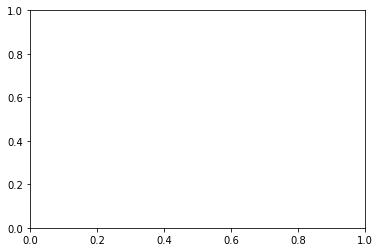

In [15]:
plt.plot(timebase,test[:, 0,0], ".")